In [1]:
import os
import itertools
import random
import copy
import json

import numpy as np

from models import Discriminator, weights_init_normal, GeneratorResNet
from utils import ReplayBuffer, LambdaLR

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

from easydict import EasyDict as edict

import torch
from torch.autograd import Variable
import torch.nn as nn

import sys
sys.path.append("../discogan")
from my_utils import load_dataset, LoaderSampler, tensor2img, get_Z_pushed_loader_stats
from fid_score import calculate_frechet_distance


batchsize = 1

opt = edict({
    "devices": [5],
    "epoch": 0,
    "n_epochs": 200,
    "decay_epoch": 100,
    
    "batch_size": batchsize,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,

    "n_residual_blocks": 9,
    "lambda_cyc": 10.0,
    "lambda_id": 5.0,

    "image_save_interval": (500 * 64) // batchsize,
    "model_save_interval": (500 * 64) // batchsize
})

In [2]:
DATASET1, DATASET1_PATH = 'dtd', '../../../data/dtd/images'
DATASET2, DATASET2_PATH = 'shoes', '../../../data/shoes_128.hdf5'

IMG_SIZE = 128

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

device = f'cuda:{opt.devices[0]}'
input_shape = (3, IMG_SIZE, IMG_SIZE)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32)

n_batches = min(len(train_loader_a), len(train_loader_b))

X_sampler = LoaderSampler(train_loader_a, device=device)
X_test_sampler = LoaderSampler(test_loader_a, device=device)
Y_sampler = LoaderSampler(train_loader_b, device=device)
Y_test_sampler = LoaderSampler(test_loader_b, device=device)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(12)
Y_fixed = Y_sampler.sample(12)

X_test_fixed = X_test_sampler.sample(12)
Y_test_fixed = Y_test_sampler.sample(12)

Keys: <KeysViewHDF5 ['imgs']>


In [3]:
input_shape = (3, IMG_SIZE, IMG_SIZE)

G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)

path = "model_iter_220000.pth"

path_to_load = os.path.join("../../../checkpoints/cyclegan_pytorch_nips/dtd_shoes_128_epochs_5000", path)
checkpoint = torch.load(path_to_load)

In [4]:
FID_EPOCHS = 50

G_AB.load_state_dict(checkpoint["netG_A_B"])

G_AB = G_AB.to(device)

FID_EPOCHS = 50
num_calculation_fid = 10
fid_values = []

for i in range(num_calculation_fid):
    mu, sigma = get_Z_pushed_loader_stats(G_AB, X_test_sampler.loader, device,
                                          n_epochs=FID_EPOCHS)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"FID = {fid}")
    fid_values.append(fid)
    
fid_values = np.array(fid_values)
fid_mean = np.mean(fid_values)
fid_std = np.std(fid_values)
print("--------")
print(f"Mean FID = {fid_mean}")
print(f"Std FID = {fid_std}")

FID = 34.7187028952215
FID = 34.60691421579321
FID = 34.55578123266656
FID = 34.53342050825225
FID = 34.503774622689434
FID = 34.597792005541294
FID = 34.90243068172737
FID = 34.748552404955575
FID = 34.76757235591032
FID = 34.58578258460875
--------
Mean FID = 34.652072350736624
Std FID = 0.12020398363594025


In [7]:
import glob2

all_models = sorted(glob.glob("/cache/selikhanovych/ot/checkpoints/cyclegan_pytorch_nips/dtd_shoes_128_epochs_5000/models/*"))

In [ ]:
best_fid = fid

from tqdm import tqdm
for model in tqdm(all_models[10:]):
    base_model = os.path.basename(model)
    checkpoint = torch.load(model)
    
    G_AB.load_state_dict(checkpoint["netG_A_B"])

    G_AB = G_AB.to(device)

    mu, sigma = get_Z_pushed_loader_stats(G_AB, X_test_sampler.loader, device,
                                          n_epochs=FID_EPOCHS)
    current_fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"Base model = {base_model}, fid = {current_fid}")
    if current_fid < fid:
        best_model = base_model
        best_fid = current_fid
        print(f"NEW BEST FID = {current_fid}")

  0%|▍                                                                                                                                  | 1/291 [02:54<14:03:41, 174.56s/it]

Base model = model_iter_107000.pth, fid = 65.07763098242361


  1%|▉                                                                                                                                  | 2/291 [05:48<13:58:51, 174.16s/it]

Base model = model_iter_108000.pth, fid = 69.18515107577966


  1%|█▎                                                                                                                                 | 3/291 [08:45<14:02:28, 175.52s/it]

Base model = model_iter_109000.pth, fid = 48.89120163114768


  1%|█▊                                                                                                                                 | 4/291 [11:42<14:02:15, 176.08s/it]

Base model = model_iter_11000.pth, fid = 150.2570846415993


  2%|██▎                                                                                                                                | 5/291 [14:36<13:55:36, 175.30s/it]

Base model = model_iter_110000.pth, fid = 53.957574907060064


  2%|██▋                                                                                                                                | 6/291 [17:31<13:52:49, 175.33s/it]

Base model = model_iter_111000.pth, fid = 48.643576092739835


  2%|███▏                                                                                                                               | 7/291 [20:34<14:00:46, 177.63s/it]

Base model = model_iter_112000.pth, fid = 66.61458345470899


  3%|███▌                                                                                                                               | 8/291 [23:32<13:58:29, 177.77s/it]

Base model = model_iter_113000.pth, fid = 90.32358718859354


  3%|████                                                                                                                               | 9/291 [28:00<16:08:56, 206.16s/it]

Base model = model_iter_114000.pth, fid = 54.973744152953316


  3%|████▍                                                                                                                             | 10/291 [31:04<15:32:27, 199.10s/it]

Base model = model_iter_115000.pth, fid = 51.55982800915598


  4%|████▉                                                                                                                             | 11/291 [34:01<14:58:38, 192.56s/it]

Base model = model_iter_116000.pth, fid = 58.026194126784446


  4%|█████▎                                                                                                                            | 12/291 [36:54<14:27:45, 186.62s/it]

Base model = model_iter_117000.pth, fid = 52.84383719525374


  4%|█████▊                                                                                                                            | 13/291 [39:50<14:08:46, 183.19s/it]

Base model = model_iter_118000.pth, fid = 78.34635095231582


  5%|██████▎                                                                                                                           | 14/291 [42:47<13:57:36, 181.43s/it]

Base model = model_iter_119000.pth, fid = 53.80239268182598


  5%|██████▋                                                                                                                           | 15/291 [45:43<13:47:26, 179.88s/it]

Base model = model_iter_12000.pth, fid = 157.34503266510507


  5%|███████▏                                                                                                                          | 16/291 [48:38<13:37:28, 178.36s/it]

Base model = model_iter_120000.pth, fid = 65.11444940637733


  6%|███████▌                                                                                                                          | 17/291 [51:31<13:26:45, 176.66s/it]

Base model = model_iter_121000.pth, fid = 52.84003304625924


  6%|████████                                                                                                                          | 18/291 [54:28<13:24:49, 176.88s/it]

Base model = model_iter_122000.pth, fid = 82.55861902706363


  7%|████████▍                                                                                                                         | 19/291 [57:24<13:20:21, 176.55s/it]

Base model = model_iter_123000.pth, fid = 47.71263739993833


  7%|████████▊                                                                                                                       | 20/291 [1:00:19<13:15:19, 176.09s/it]

Base model = model_iter_124000.pth, fid = 67.90625594278075


  7%|█████████▏                                                                                                                      | 21/291 [1:03:12<13:07:53, 175.09s/it]

Base model = model_iter_125000.pth, fid = 60.31792921938205


  8%|█████████▋                                                                                                                      | 22/291 [1:06:12<13:11:49, 176.61s/it]

Base model = model_iter_126000.pth, fid = 58.14444511146081


  8%|██████████                                                                                                                      | 23/291 [1:09:10<13:10:59, 177.09s/it]

Base model = model_iter_127000.pth, fid = 63.42220740023782


  8%|██████████▌                                                                                                                     | 24/291 [1:12:04<13:03:51, 176.15s/it]

Base model = model_iter_128000.pth, fid = 63.572725709463754


  9%|██████████▉                                                                                                                     | 25/291 [1:14:59<12:59:38, 175.86s/it]

Base model = model_iter_129000.pth, fid = 60.52523440652806


  9%|███████████▍                                                                                                                    | 26/291 [1:18:00<13:03:16, 177.35s/it]

Base model = model_iter_13000.pth, fid = 144.77184865239084


  9%|███████████▉                                                                                                                    | 27/291 [1:20:59<13:01:42, 177.66s/it]

Base model = model_iter_130000.pth, fid = 47.123122917196156


 10%|████████████▎                                                                                                                   | 28/291 [1:23:52<12:53:49, 176.54s/it]

Base model = model_iter_131000.pth, fid = 66.60840406336118


 10%|████████████▊                                                                                                                   | 29/291 [1:26:48<12:49:50, 176.30s/it]

Base model = model_iter_132000.pth, fid = 76.3194693892259


 10%|█████████████▏                                                                                                                  | 30/291 [1:29:47<12:50:43, 177.18s/it]

Base model = model_iter_133000.pth, fid = 42.51778188415108


 11%|█████████████▋                                                                                                                  | 31/291 [1:32:45<12:47:53, 177.21s/it]

Base model = model_iter_134000.pth, fid = 64.8664615314826


 11%|██████████████                                                                                                                  | 32/291 [1:35:39<12:41:43, 176.46s/it]

Base model = model_iter_135000.pth, fid = 67.73322724524431


 11%|██████████████▌                                                                                                                 | 33/291 [1:38:35<12:38:10, 176.32s/it]

Base model = model_iter_136000.pth, fid = 64.72127765006672


 12%|██████████████▉                                                                                                                 | 34/291 [1:41:32<12:35:32, 176.39s/it]

Base model = model_iter_137000.pth, fid = 73.40145354290902


 12%|███████████████▍                                                                                                                | 35/291 [1:44:29<12:33:23, 176.58s/it]

Base model = model_iter_138000.pth, fid = 68.01484470518577


 12%|███████████████▊                                                                                                                | 36/291 [1:47:29<12:34:25, 177.51s/it]

Base model = model_iter_139000.pth, fid = 74.99435428384402


 13%|████████████████▎                                                                                                               | 37/291 [1:50:23<12:27:57, 176.68s/it]

Base model = model_iter_14000.pth, fid = 204.3167955943402


 13%|████████████████▋                                                                                                               | 38/291 [1:53:22<12:27:43, 177.33s/it]

Base model = model_iter_140000.pth, fid = 61.25778101361567


 13%|█████████████████▏                                                                                                              | 39/291 [1:56:24<12:30:49, 178.77s/it]

Base model = model_iter_141000.pth, fid = 90.89207484694597


 14%|█████████████████▌                                                                                                              | 40/291 [1:59:21<12:25:42, 178.26s/it]

Base model = model_iter_142000.pth, fid = 74.9506756407821


 14%|██████████████████                                                                                                              | 41/291 [2:02:18<12:20:08, 177.64s/it]

Base model = model_iter_143000.pth, fid = 106.2796157201274


 14%|██████████████████▍                                                                                                             | 42/291 [2:05:49<12:58:49, 187.67s/it]

Base model = model_iter_144000.pth, fid = 112.07572573654971


 15%|██████████████████▉                                                                                                             | 43/291 [2:08:59<12:59:33, 188.60s/it]

Base model = model_iter_145000.pth, fid = 87.46620101973733


 15%|███████████████████▎                                                                                                            | 44/291 [2:11:56<12:41:30, 184.98s/it]

Base model = model_iter_146000.pth, fid = 53.86641066199917


 15%|███████████████████▊                                                                                                            | 45/291 [2:14:54<12:29:55, 182.91s/it]

Base model = model_iter_147000.pth, fid = 57.842743174839626


 16%|████████████████████▏                                                                                                           | 46/291 [2:18:10<12:42:51, 186.82s/it]

Base model = model_iter_148000.pth, fid = 66.13889625337524


 16%|████████████████████▋                                                                                                           | 47/291 [2:21:14<12:36:30, 186.02s/it]

Base model = model_iter_149000.pth, fid = 57.00019424493735


 16%|█████████████████████                                                                                                           | 48/291 [2:24:25<12:39:39, 187.57s/it]

Base model = model_iter_15000.pth, fid = 190.0693289699717


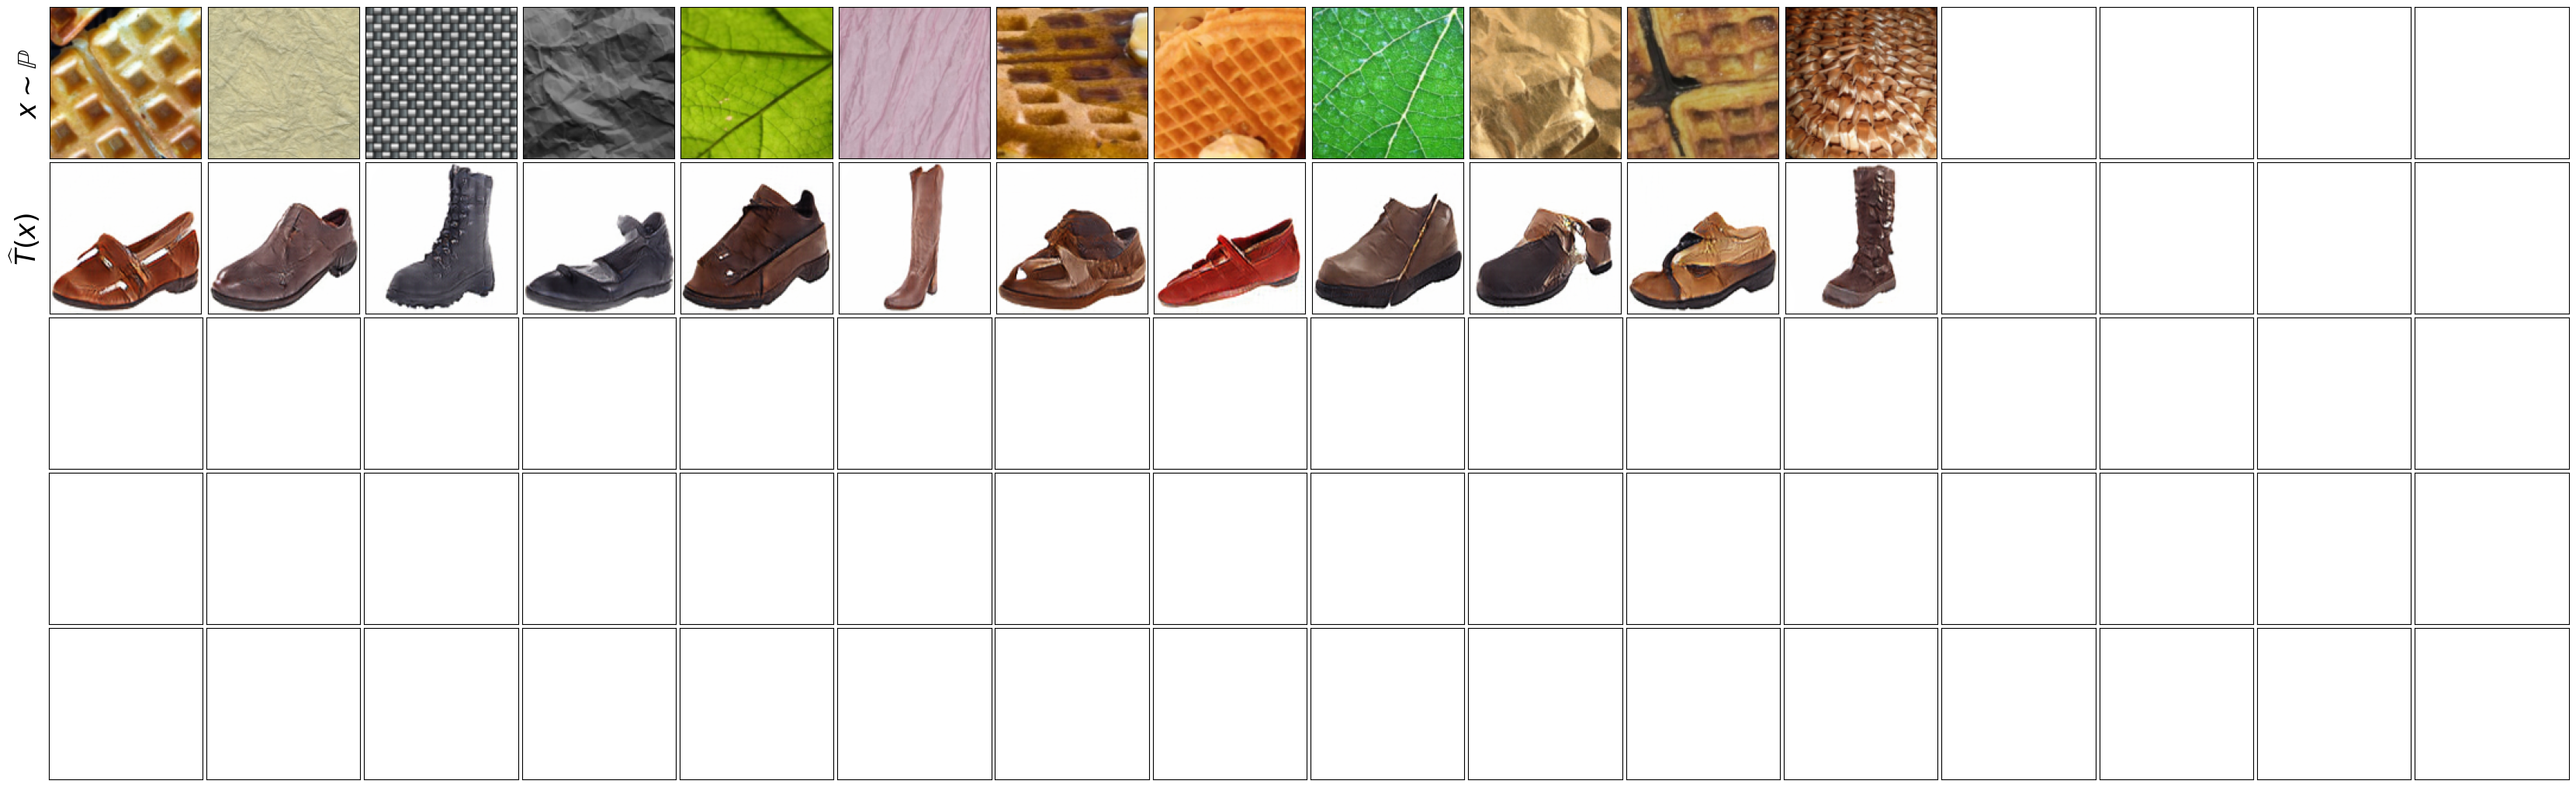

In [5]:
G_AB.eval()

AB_test = G_AB(X_test_fixed).detach()

fake_Y_test_numpy = tensor2img(AB_test)
real_X_test_numpy = tensor2img(X_test_fixed)

fig, axes = plt.subplots(5, 16, figsize=(16*2+1,10), dpi=100)
X_tensor = real_X_test_numpy

for j in range(12):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    
    axes[1][j].imshow(fake_Y_test_numpy[j])
    axes[1][j].get_xaxis().set_visible(False)
    axes[1][j].set_yticks([])
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=25)
title = '\widehat{T}(x)'
axes[1, 0].set_ylabel(r'${}$'.format(title), fontsize=25)  

for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    
fig.tight_layout(pad=0.001)    
plt.savefig("cycle_textures2shoes_test.png")